In [3]:
# Make the repo root importable so `from finscenlab.core ...` works
import sys, os, pathlib
repo_root = pathlib.Path(__file__).resolve().parents[1] if "__file__" in globals() else pathlib.Path(os.getcwd()).parents[0]
sys.path.insert(0, str(repo_root))

# Import the core components
from datetime import date
from finscenlab.core import Scenario, ABrick, LBrick, FBrick, StartLink, PrincipalLink, LMortgageSpec, ConfigError, term_from_amort
from finscenlab.kinds import K
import finscenlab.strategies  # This registers the default strategies

# Import for visualization
import matplotlib.pyplot as plt
import pandas as pd

print("✅ All imports successful!")

✅ All imports successful!


# FinScenLab Quickstart

This notebook demonstrates the core concepts of FinScenLab - a strategy-driven brick architecture for financial scenario modeling.

## Key Concepts

- **FinBrickABC**: Abstract base class for all financial instruments
- **ABrick/LBrick/FBrick**: Concrete classes for Assets, Liabilities, and Flows
- **Strategies**: Pluggable behaviors selected by `kind` discriminator
- **Registry**: Maps `kind` strings to strategy implementations
- **Scenario Engine**: Orchestrates simulation and cash flow routing

## Architecture Benefits

- **Extensible**: Add new behaviors by registering strategies, no class changes
- **Modular**: Each brick is self-contained with clear interfaces
- **Composable**: Link bricks together (e.g., mortgage auto-calculates from property)
- **Explicit**: Cash flows are explicitly routed, no hidden assumptions


## Create Financial Bricks

Let's build a simple scenario: buying a house with a mortgage, using seed money and salary income.


In [52]:
# Cash account - this will receive all routed cash flows
cash = ABrick(
    id="cash:EUR", 
    name="Main Cash Account", 
    kind=K.A_CASH,
    spec={
        "initial_balance": 0.0, 
        "interest_pa": 0.00  # 2% annual interest
    }
)

# Monthly salary income
salary = FBrick(
    id="salary", 
    name="Net Salary", 
    kind=K.F_INCOME,
    spec={
        "amount_monthly": 1_157.04,  # €5k/month base salary
        "annual_step_pct": 0.00,  # 4% annual increase
        "step_month": 4  # Escalate in June every year
    }
)

# Monthly living expenses
living = FBrick(
    id="living", 
    name="Living Costs", 
    kind=K.F_EXP_LIVING,
    spec={"amount_monthly": 1_800}
)

# Seed money - initial capital injection
seed = FBrick(
    id="seed", 
    name="Owner Equity Seed", 
    kind=K.F_TRANSFER,
    start_date= date(2018, 5, 1),
    spec={"amount": 70_000},
)


HOUSE_BUY_DATE = date(2018, 10, 1)
# House purchase
house = ABrick(
    id="flat_hamburg", 
    name="Hamburg Flat", 
    kind=K.A_PROPERTY,
    start_date= HOUSE_BUY_DATE,
    # duration_m=18,                # Run for 18 months
    spec={
        "price": 492_000, 
        "fees_pct": 0.095,  # 9.5% fees (notary, taxes, etc.)
        "appreciation_pa": 0.05,  # 3% annual appreciation
        "finance_fees": False  # Pay fees upfront, not financed
    }
)

# Mortgage with new LMortgageSpec
mortgage_commerzbank = LBrick(
    id="mort_10y_commerzbank", 
    name="Commerzbank 10-Year Fixed Mortgage", 
    kind=K.L_MORT_ANN,
    start_date=HOUSE_BUY_DATE,
    end_date=date(2028, 10, 1),
    links={
        "principal": PrincipalLink(nominal=420_000).__dict__
    },
    spec=LMortgageSpec(
        rate_pa=0.013,           # 1.3% annual rate
        term_months=600,         # 50 years to zero
        fix_rate_months=120      # 10 years fixed
    )
)

# Mortgage with new LMortgageSpec
mortgage_kfw = LBrick(
    id="mort_25y_kfw", 
    name="KFW 10-Year Fixed Mortgage", 
    kind=K.L_MORT_ANN,
    start_date=HOUSE_BUY_DATE,
    links={
        "principal": PrincipalLink(nominal=50_000).__dict__
    },
    spec=LMortgageSpec(
        rate_pa=0.017,           # 1.3% annual rate
        term_months=300,         # 25 years to zero
    )
)

# Seed money - initial capital injection
wustenrot_capital = FBrick(
    id="capital_wustenrot", 
    name="Wustenrot Capital",
    kind=K.F_TRANSFER,
    start_date= date(2028, 10, 1),
    spec={"amount": 80_000},
)

# Mortgage with new LMortgageSpec
mortgage_wustenrot = LBrick(
    id="mort_wustenrot", 
    name="Wustenrot Mortgage",
    kind=K.L_MORT_ANN,
    start_date=date(2028, 10, 1),
    links={
        "principal": PrincipalLink(nominal=120_000).__dict__
    },
    spec=LMortgageSpec(
        rate_pa=0.02,           # 2% annual rate
        term_months=180,         # 15 years to zero
    )
)

# Mortgage with new LMortgageSpec
mortgage_anschluss = LBrick(
    id="mort_anschluss", 
    name="Anschluss Mortgage",
    kind=K.L_MORT_ANN,
    start_date=date(2028, 10, 1),
    links={
        "principal": PrincipalLink(nominal=150_000).__dict__
    },
    spec=LMortgageSpec(
        rate_pa=0.035,           # 2% annual rate
        term_months=300,         # 25 years to zero
    )
)

# Monthly salary income
rent_flat = FBrick(
    id="rent", 
    name="Brutto Rent", 
    kind=K.F_INCOME,
    start_date=date(2026, 1, 1),
    spec={
        "amount_monthly": 1_550,
        "annual_step_pct": 0.02,
        "step_month": 12
    }
)

etf = ABrick(
    id="etf", 
    name="S&P 500 ETF", 
    kind=K.A_INV_ETF,
    start_date=date(2030, 1, 1),  # Start investing 2 months after house
    spec={
        "price0": 100,
        "drift_pa": 0.1,  # 10% annual growth
        "initial_units": 0,
        "buy_at_start": {"amount": 1000},  # Initial €1k investment
        "dca": {
            "mode": "amount",
            "amount": 500,  # €250/month DCA
            "start_offset_m": 1,  # Start next month
            "months": None,
            "annual_step_pct": 0.03  # +3% per year
        },
        "reinvest_dividends": True,  # Reinvest dividends
        "events_level": "major"
    }
)


print("Created all financial bricks!")
print(f"House price: €{house.spec['price']:,}")
print(f"Monthly salary: €{salary.spec['amount_monthly']:,}")
print(f"Monthly expenses: €{living.spec['amount_monthly']:,}")


Created all financial bricks!
House price: €492,000
Monthly salary: €1,157.04
Monthly expenses: €1,800


## Run the Scenario

Now let's create a scenario and run it for 30 years (360 months).


In [53]:
pd.set_option('display.max_rows', 600)
pd.options.display.float_format = '{:,.2f} €'.format

# Create the scenario with all our bricks
scenarioA = Scenario(
    id="scenA", 
    name="Test",
    # bricks=[cash, house, mortgage, salary, living, etf]
    bricks=[cash, salary, seed, house, mortgage_commerzbank, mortgage_kfw, mortgage_wustenrot, wustenrot_capital, mortgage_anschluss, rent_flat]
)
# Run the simulation for 30 years starting January 2026
resultsA = scenarioA.run(start=date(2017, 1, 1), months=600)
resultsA = resultsA["views"].yearly()
# resultsA = scenarioA.aggregate_totals("M")
scenarioA.validate(mode="warn")

# print("Scenario completed!")
# print(f"Simulation period: {resultsA.index[0]} to {resultsA.index[-1]}")
# print(f"Total months simulated: {len(resultsA)}")

# Show first few months
resultsA


,cash_in,cash_out,net_cf,assets,liabilities,equity,cash,non_cash
t,,,,,,,,
2017,"13,884.48 €",0.00 €,"13,884.48 €","13,884.48 €",0.00 €,"13,884.48 €","13,884.48 €",0.00 €
2018,"553,884.48 €","541,054.08 €","12,830.40 €","522,731.98 €","468,736.86 €","53,995.13 €","26,714.88 €","496,017.10 €"
2019,"13,884.48 €","13,884.49 €",-0.01 €,"547,532.83 €","461,096.50 €","86,436.33 €","26,714.87 €","520,817.96 €"
2020,"13,884.48 €","13,884.49 €",-0.01 €,"573,573.72 €","453,349.63 €","120,224.08 €","26,714.86 €","546,858.86 €"
2021,"13,884.48 €","13,884.49 €",-0.01 €,"600,916.65 €","445,494.76 €","155,421.89 €","26,714.85 €","574,201.80 €"
2022,"13,884.48 €","13,884.49 €",-0.01 €,"629,626.73 €","437,530.36 €","192,096.37 €","26,714.84 €","602,911.89 €"
2023,"13,884.48 €","13,884.49 €",-0.01 €,"659,772.31 €","429,454.87 €","230,317.45 €","26,714.83 €","633,057.48 €"
2024,"13,884.48 €","13,884.49 €",-0.01 €,"691,425.18 €","421,266.72 €","270,158.46 €","26,714.82 €","664,710.36 €"
2025,"13,884.48 €","13,884.49 €",-0.01 €,"724,660.69 €","412,964.32 €","311,696.37 €","26,714.81 €","697,945.88 €"


In [33]:
print(resultsA["totals"].iloc[-1])
print(resultsB["totals"].iloc[-1])

cash_in        4,500.00 €
cash_out       2,846.89 €
net_cf         1,653.11 €
assets     1,660,805.65 €
debt               0.00 €
equity     1,660,805.65 €
cash         189,150.47 €
Name: 2055-02-01 00:00:00, dtype: float64
cash_in        4,500.00 €
cash_out       1,800.00 €
net_cf         2,700.00 €
assets     1,080,425.70 €
debt               0.00 €
equity     1,080,425.70 €
cash         409,952.94 €
Name: 2055-02-01 00:00:00, dtype: float64


## Analyze Results

Let's examine the key metrics and visualize the evolution over time.


In [8]:
# Key metrics at the end of the simulation
final_month = results["totals"].iloc[-1]
print("=== FINAL RESULTS (30 years) ===")
print(f"Cash Balance: €{final_month['assets'] - final_month['debt']:,.2f}")
print(f"House Value: €{results['outputs']['house_tls']['asset_value'][-1]:,.2f}")
print(f"Remaining Mortgage: €{final_month['debt']:,.2f}")
print(f"Net Worth (Equity): €{final_month['equity']:,.2f}")
print(f"Monthly Net Cash Flow: €{final_month['net_cf']:,.2f}")

# Calculate some key ratios
house_value = results['outputs']['house_tls']['asset_value'][-1]
original_price = house.spec['price']
appreciation = (house_value - original_price) / original_price * 100
print(f"\nHouse Appreciation: {appreciation:.1f}% over 30 years")

# Check if mortgage is paid off
mortgage_balance = results['outputs']['mort_10y']['debt_balance'][-1]
if mortgage_balance < 1:
    print("✅ Mortgage fully paid off!")
else:
    print(f"⚠️  Mortgage still has €{mortgage_balance:,.2f} remaining")


=== FINAL RESULTS (30 years) ===
Cash Balance: €1,321,780.30
House Value: €759,517.46
Remaining Mortgage: €0.00
Net Worth (Equity): €1,321,780.30
Monthly Net Cash Flow: €5,400.00

House Appreciation: 80.8% over 30 years
✅ Mortgage fully paid off!


Matplotlib is building the font cache; this may take a moment.


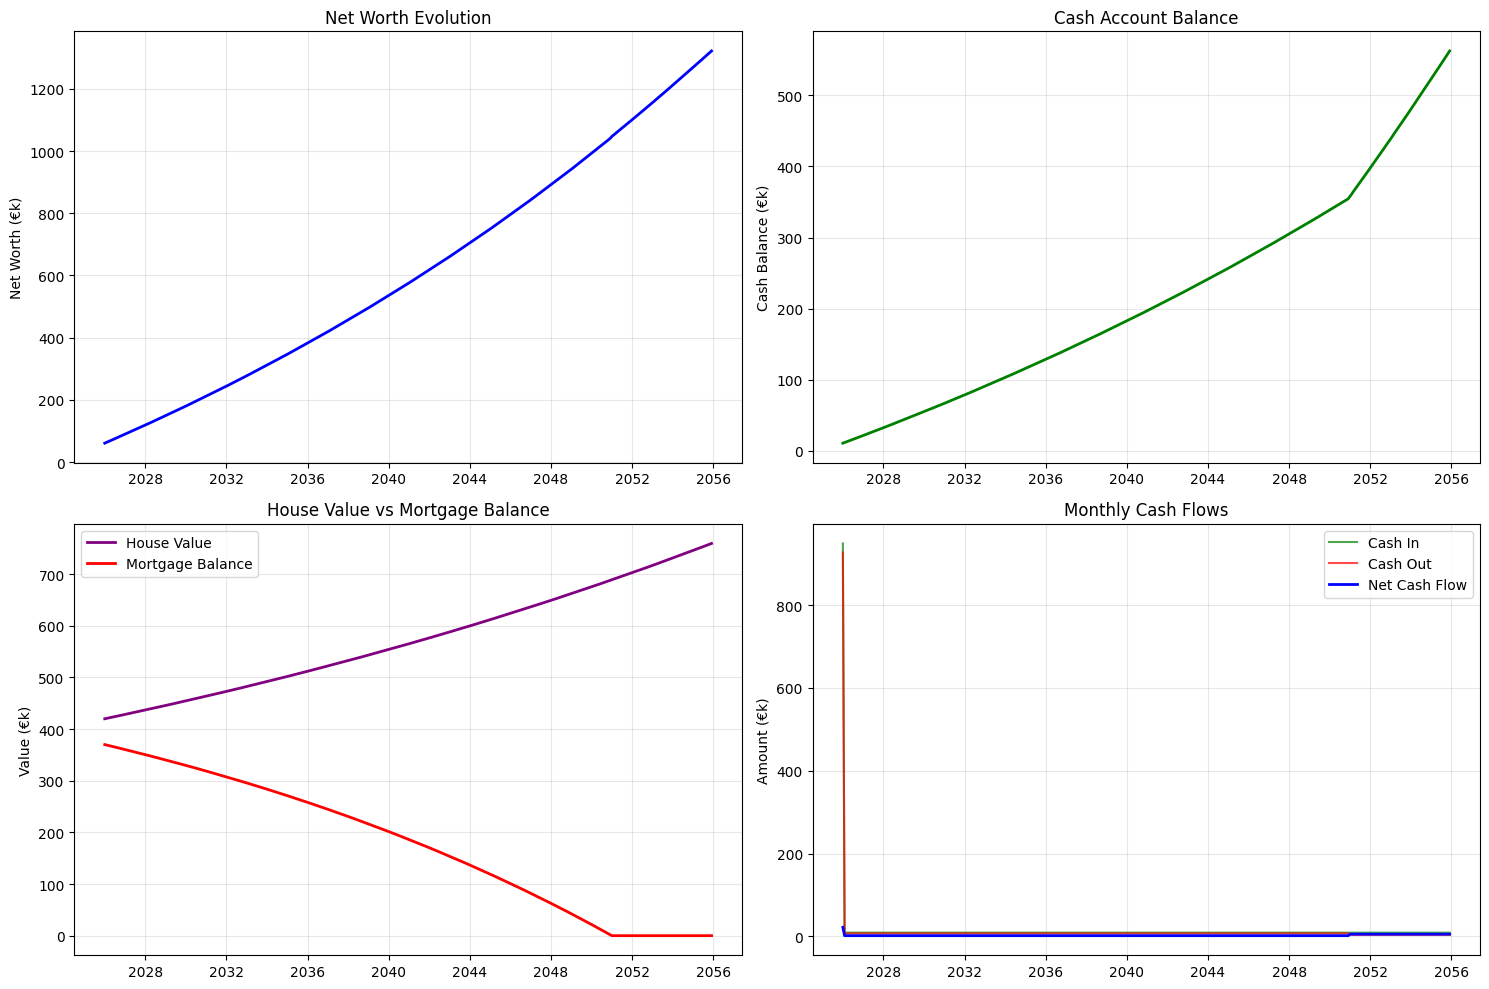

In [10]:
import matplotlib.pyplot as plt

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Net Worth Evolution
axes[0, 0].plot(results["totals"].index, results["totals"]["equity"] / 1000, 'b-', linewidth=2)
axes[0, 0].set_title("Net Worth Evolution")
axes[0, 0].set_ylabel("Net Worth (€k)")
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Cash Balance
cash_balance = results["outputs"]["cash:EUR"]["asset_value"]
axes[0, 1].plot(results["totals"].index, cash_balance / 1000, 'g-', linewidth=2)
axes[0, 1].set_title("Cash Account Balance")
axes[0, 1].set_ylabel("Cash Balance (€k)")
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: House Value vs Mortgage Balance
house_value = results["outputs"]["house_tls"]["asset_value"]
mortgage_balance = results["outputs"]["mort_10y"]["debt_balance"]
axes[1, 0].plot(results["totals"].index, house_value / 1000, 'purple', linewidth=2, label='House Value')
axes[1, 0].plot(results["totals"].index, mortgage_balance / 1000, 'red', linewidth=2, label='Mortgage Balance')
axes[1, 0].set_title("House Value vs Mortgage Balance")
axes[1, 0].set_ylabel("Value (€k)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Monthly Cash Flows
axes[1, 1].plot(results["totals"].index, results["totals"]["cash_in"] / 1000, 'green', alpha=0.7, label='Cash In')
axes[1, 1].plot(results["totals"].index, results["totals"]["cash_out"] / 1000, 'red', alpha=0.7, label='Cash Out')
axes[1, 1].plot(results["totals"].index, results["totals"]["net_cf"] / 1000, 'blue', linewidth=2, label='Net Cash Flow')
axes[1, 1].set_title("Monthly Cash Flows")
axes[1, 1].set_ylabel("Amount (€k)")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Architecture Benefits Demonstrated

This example shows several key benefits of the FinScenLab architecture:

### 1. **Strategy Pattern in Action**
- The `kind` discriminator (`a.cash`, `a.property`, `l.mortgage.annuity`, etc.) automatically selects the right strategy
- No need for complex inheritance hierarchies or switch statements

### 2. **Modular Design**
- Each brick is self-contained with its own parameters (`spec`)
- Bricks can be easily swapped or modified without affecting others

### 3. **Automatic Linking**
- The mortgage automatically calculates its principal from the house price minus down payment
- This is handled through the `links` mechanism without tight coupling

### 4. **Explicit Cash Flow Routing**
- All cash flows are explicitly routed to the cash account
- No hidden assumptions or magic - everything is transparent

### 5. **Easy Extension**
To add new behaviors, you would:
1. Create a new strategy class implementing the appropriate interface
2. Register it in the registry with a new `kind` string
3. Use the new `kind` when creating bricks

No changes to existing code required!
